## Import Libraries

numpy, matplotlib, sklearn, pywt, Keras

======================================================================

In [109]:
%matplotlib inline

import codecs

import numpy as np
from numpy.lib import scimath

from matplotlib import pyplot as plt

from mne import create_info, EpochsArray
from mne.baseline import rescale
from mne.time_frequency import tfr_array_stockwell

from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.optimizers import RMSprop
from livelossplot import PlotLossesKeras
print(__doc__)

Automatically created module for IPython interactive environment


## Data Generation (Synthetic Electromagnetic Time Series)
-------------

Data with a known spectro-temporal structure and randoom noise.

======================================================================

In [93]:
n_times = 225279
sfreq = 4096

comp = np.empty(shape=(n_times,4))
for i in range(0, 3):
    with codecs.open(['Ex1','Ey1','Hx1','Hy1'][i]+'.ascii', encoding='utf-8-sig') as f:
        comp[:,i] = np.loadtxt(f)

subset = 2048       
t = np.arange(subset, dtype=np.float) / sfreq

w = 18
Ex = comp[:,0][subset*w:subset*(w+1)]
Ey = comp[:,1][subset*w:subset*(w+1)]
Bx = comp[:,2][subset*w:subset*(w+1)] 
By = comp[:,3][subset*w:subset*(w+1)]

Simulate Noise and add to signal
-------------

We'll simulate data with a known spectro-temporal structure.



## Plot Electromagnetic Noisy Time Series Componets

======================================================================

Text(0.5,1,'Ey')

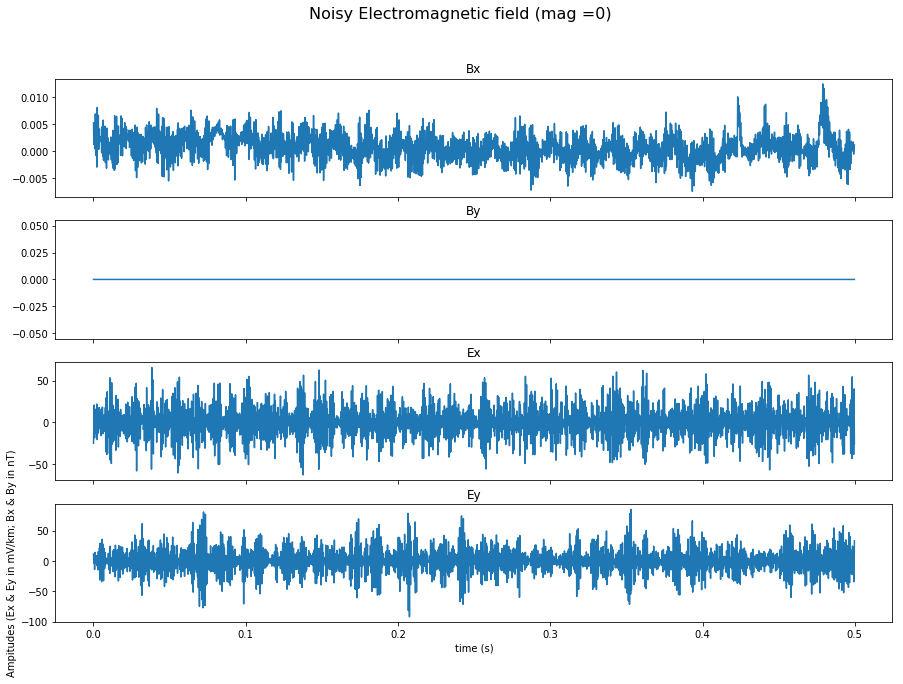

In [95]:
f, axarr = plt.subplots(4, sharex=True)
f.set_size_inches(15,10)
plt.xlabel('time (s)')
plt.ylabel('Ampitudes (Ex & Ey in mV/km; Bx & By in nT)')
plt.suptitle('Noisy Electromagnetic field (mag ='+str(noise_mag)+')', fontsize=16)

axarr[0].plot(t,Bx)
axarr[0].set_title("Bx")
axarr[1].plot(t,By)
axarr[1].set_title("By")
axarr[2].plot(t,Ex)
axarr[2].set_title("Ex")
axarr[3].plot(t,Ey)
axarr[3].set_title("Ey")

In [110]:
signal = np.array([[Bx]])
sfreq = sfreq #The sampling frequency.
fmin = None # float | The minimum frequency to include. If None defaults to the minimum fft frequency greater than zero.
fmax = None # float | The maximum frequency to include. If None defaults to the maximum fft.
n_fft =  None # int | The length of the windows used for FFT. If None, it defaults to the next 
## power of 2 larger than the signal length.
width = 1 # float | The width of the Gaussian window. If < 1, increased temporal resolution,
# if > 1, increased frequency resolution. Defaults to 1. (classical S-Transform).
decim = 1 # The decimation factor on the time axis. To reduce memory usage.
return_itc = False #  bool | Return intertrial coherence (ITC) as well as averaged power.
n_jobs = 1 # int | Number of parallel jobs to use.

### Calculate the Strasform MNE array function
[st_power_Bx, st_itc_Bx, st_freqs_Bx] = tfr_array_stockwell(signal, sfreq, fmin, fmax, n_fft, width, decim, return_itc, n_jobs)


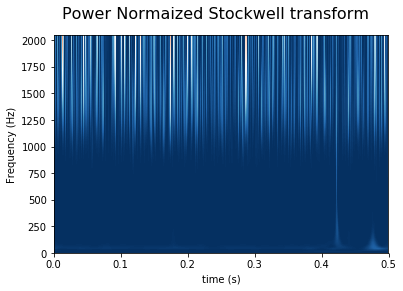

In [118]:
plt.xlabel('time (s)')
plt.ylabel('Frequency (Hz)')
plt.suptitle('Power Normaized Stockwell transform', fontsize=16)

plt.pcolormesh(t, st_freqs_Bx, st_power_Bx[0], cmap='RdBu_r')

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
f.colorbar(im, cax = cbar_ax)

## Normaize

In [119]:
N_st_power_Bx = st_power_Bx[0]/np.amax(st_power_Bx[0])

## Split

In [121]:
[BxWT, TBxWT] = np.split(N_st_power_Bx,2,1)

## Roll

In [122]:
TBxWT = np.roll(TBxWT, 32)

# Keras LSTM Regression

## Define training data: input tensors and target tensors.
===================================================================================


In [128]:
# Generate dummy data
x_train = BxWT.T
y_train = TBxWT.T
x_val = BxWT.T
y_val = TBxWT.T

# reshape input to be [samples, timesteps, features] expected input data shape: (batch_size, timesteps, data_dim)
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_val = np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1]))
in_out_neurons = x_train.shape

## Define a network of layers (or model) that maps your inputs to your targets. 


In [130]:
layers = [LSTM(in_out_neurons[2], return_sequences=True, stateful=True, batch_input_shape=(32,1,in_out_neurons[2])),
          LSTM(in_out_neurons[2], return_sequences=True, stateful=True),
          LSTM(in_out_neurons[2]),
          Dense(in_out_neurons[2], activation='linear', use_bias=True)]

model = Sequential(layers)

## Configure the learning process by choosing a loss function, an optimizer, and some metrics to monitor (compiling).


In [ ]:
RMSprop(lr=1, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Iterate on your training data by calling the fit() method of your model.

In [ ]:
history = model.fit(x_train, y_train,
                    epochs=20,
                    validation_data=(x_val, y_val),
                    callbacks=[PlotLossesKeras()],
                    verbose=0)

## Predict Denoised Eectromagnetic Components

In [ ]:
prediction = model.predict(x_val)

fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(prediction.T, interpolation='nearest', aspect='auto' )